In [9]:
import torch
import pytorch_lightning as pl
import yaml
import sys
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch.nn.functional as F

In [2]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")

In [10]:
from scripts.diffusion.schedules import TimestepSampler
from scripts.diffusion.ResUnet_timeembed import Unet
from scripts.maploader.maploader import get_data, get_minmaxnormalized_data
from run.diffusion.run_diffusion import DDPM
from scripts.utils.diffusion_utils import extract

In [4]:
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


1234

# Data Loading

In [5]:
target = "difference"
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
ckpt_dir = f"{base_dir}/ckpt_logs/diffusion/{target}/{target}_cosine_o4_b24/version_1"

with open(f"{ckpt_dir}/hparams.yaml", 'r') as stream:
    config_dict = yaml.safe_load(stream)

In [6]:
BATCH_SIZE = 48#config_dict['train']['batch_size']
PATCH_SIZE = 12 * (config_dict['data']['order'])**2

lr = get_data(config_dict['data']['LR_dir'], config_dict['data']['n_maps'], config_dict['data']['nside'], config_dict['data']['order'], issplit=True)
hr = get_data(config_dict['data']['HR_dir'], config_dict['data']['n_maps'], config_dict['data']['nside'], config_dict['data']['order'], issplit=True)

hr, transforms_hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_minmaxnormalized_data(hr)
print("HR data loaded. min: {}, max: {}".format(range_min_hr, range_max_hr))
print("HR data normalized. min: {}, max: {}".format(hr.min(), hr.max()))

if target == 'difference':
    lr = transforms_hr(lr)
    print("LR data normalized by HR range. min: {}, max: {}".format(lr.min(), lr.max()))
    data_input, data_condition = hr-lr, lr
elif target == 'HR':
    lr, transform_lr, inverse_transform_lr, range_min_lr, range_max_lr = get_minmaxnormalized_data(lr)
    print("LR data loaded. min: {}, max: {}".format(range_min_lr, range_max_lr))
    data_input, data_condition = hr, lr
else:
    raise ValueError("target must be 'difference' or 'HR'")

HR data loaded. min: 0.0, max: 2.903632402420044
HR data normalized. min: -1.0, max: 1.0
LR data normalized by HR range. min: -1.0, max: 0.38642704486846924


In [7]:
# set up model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ckpt_path= sorted(glob(f"{ckpt_dir}/checkpoints/*.ckpt"))[-1]

#get sampler type
timesteps = int(config_dict['diffusion']['timesteps'])
sampler = TimestepSampler(timesteps=timesteps, sampler_type=config_dict['diffusion']['sampler_type'])

Sampler type uniform


In [8]:
#get model
model = DDPM(Unet, config_dict, sampler = sampler).to(device)
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt["state_dict"], strict=False)
model.eval()
print("Model loaded")

#get diffusion
tmp_diffusion = model.diffusion

Model loaded


In [23]:
print("Start Diffusion")
test_batch =24
tmp_sample =data_input[:test_batch].to(device)
tmp_lr = data_condition[:test_batch].to(device)
img = torch.randn(tmp_sample.shape, device=device)
imgs = []
with torch.no_grad():
    for j in reversed(range(990, timesteps)):
        t = torch.full((test_batch,), j, device=device, dtype=torch.long)
        img = tmp_diffusion.p_sample(model.model, img, t, t_index=j, condition=tmp_lr)
        imgs.append(img.detach().cpu().numpy())
        if img.min() < -1e3 or img.max() > 1e3:
            print("Diverged at step {}, aborting.".format(j))
            break
        loss = tmp_diffusion.p_losses(model.model, tmp_sample, t, condition=tmp_lr, loss_type=config_dict['diffusion']['loss_type'])
        print('Current step {}, Loss {}'.format(j, loss), flush=True)

Start Diffusion
Current step 999, Loss 0.012871947139501572
Current step 998, Loss 0.012785779312252998
Current step 997, Loss 0.01290515810251236
Diverged at step 996, aborting.


In [11]:
x= data_input[:2].to(device)
condition=data_condition[:2].to(device)
img = torch.randn(x.shape, device=device)

In [24]:
for im in imgs:
    print(im.min(), im.max())

-26.555298 28.694872
-53.443314 42.37733
-265.76953 126.60356
-1330.4753 419.42276


In [12]:
with torch.no_grad():
    for j in reversed(range(990, timesteps)):
        t = torch.full((2,), j, device=device, dtype=torch.long)
        betas_t = extract(tmp_diffusion.betas, t, img.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            tmp_diffusion.sqrt_one_minus_alphas_cumprod, t, img.shape
        )
        sqrt_recip_alphas_t = extract(tmp_diffusion.sqrt_recip_alphas, t, img.shape)
        model_output = model.model(img, t, condition=condition)
        model_mean = sqrt_recip_alphas_t * (
                img - betas_t * model_output / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = extract(tmp_diffusion.posterior_variance, t, img.shape)
        noise = torch.randn_like(img)
        x_t = tmp_diffusion.q_sample(x_start=x, t=t, noise=torch.randn_like(x))
        predicted_noise = model.model(x_t, t, condition=condition)
        loss = F.smooth_l1_loss(noise, predicted_noise)
        print("step {}: current loss {}".format(j, loss))
        img = model_mean + torch.sqrt(posterior_variance_t) * noise

step 999: current loss 0.7248194813728333
step 998: current loss 0.7223145961761475
step 997: current loss 0.7238543033599854
step 996: current loss 0.7325335741043091
step 995: current loss 0.733242392539978
step 994: current loss 0.7350778579711914
step 993: current loss 0.7247142195701599
step 992: current loss 0.7256264686584473
step 991: current loss 0.7260622978210449
step 990: current loss 0.7216283082962036


# Visualization

In [11]:
def read_maps(map_dir, diffsteps=100, batch_size=4):
    maps = sorted(glob(map_dir + "/*.npy"), key=lambda x: (int(x.split("/")[-1].split("_")[2]), int(x.split("/")[-1].split(".")[0].split("_")[-1])))
    map_diffused = []
    for i in range(diffsteps):
        map_steps = []
        for j in range(batch_size):
            #print("Current map: {}".format(maps[i*batch_size+j]))
            map_steps.append(np.load(maps[i*batch_size+j]))
        map_steps = np.array(map_steps)
        map_steps = np.hstack(map_steps)
        map_diffused.append(map_steps)
    map_diffused = np.array(map_diffused)
    return map_diffused

In [12]:
map_diffused = read_maps(map_dir, diffsteps=diffsteps, batch_size=NUM_BATCHES)
print(f"map_diffused.shape: {map_diffused.shape}")

map_diffused.shape: (100, 3145728)


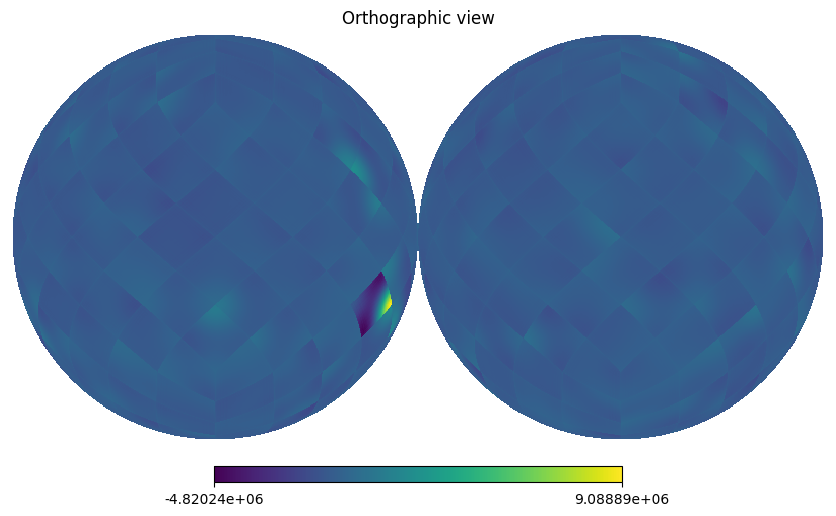

In [16]:
hp.orthview(map_diffused[-1], nest=True)

In [19]:
map_diffused = read_maps(map_dir, diffsteps=100, batch_size=16)

In [23]:
lr = get_data(lrmaps_dir, n_maps, nside, order, issplit=False)
hr = get_data(hrmaps_dir, n_maps, nside, order, issplit=False)

hr, transforms_hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_minmaxnormalized_data(hr)
print("HR data loaded. min: {}, max: {}".format(range_min_hr, range_max_hr))

lr = transforms_hr(lr)
print("LR data normalized by HR range. min: {}, max: {}".format(lr.min(), lr.max()))

HR data loaded. min: 0.0, max: 2.903632402420044
LR data normalized by HR range. min: -1.0, max: 0.38642704486846924


In [86]:
lr_hp = inverse_transforms_hr(lr).detach().cpu().numpy()[0, : , 0]
lr_sample = lr.detach().cpu().numpy()[0, : , 0]
hr_hp = inverse_transforms_hr(hr).detach().cpu().numpy()[0, : , 0]

In [61]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

def inverse_transforms_hp(x, range_min, range_max):
    x = (x + 1) / 2 * (range_max - range_min) + range_min
    return x

In [167]:
def plot_ps(cls, fig, ax):
    if len(cls) == 2:
        labels = ["input", "target"]
    elif len(cls) == 3:
        labels = ["input", "target", "output"]
    elif len(cls) == 4:
        labels = ["input", "target", "output", "diff"]
    else:
        raise ValueError("cls must be 2 or 3 or 4 length")
    ell = np.arange(len(cls[0]))
    for cl, label in zip(cls, labels):
        ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
    ax.set_xlabel("l", fontsize=12)
    ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=12)
    ax.set_yscale("log")
    ax.legend(loc="lower right", fontsize=12)
    return fig, ax

In [168]:
def plot_maps_png(i, sr_hp, lr_hp, hr_hp, png_dir, tmp_min, tmp_max, verbose=False):
    fig = plt.figure(figsize=(12,4))
    hp.mollview(sr_hp, nest=True, fig=fig, title=f'Generated Diff step_{str((99-i)*10).zfill(3)}+ LR', sub=(1,3,1), min=tmp_min, max=tmp_max)
    hp.mollview(hr_hp, nest=True, fig=fig, title='HR', sub=(1,3,2), min=tmp_min, max=tmp_max)
    hp.mollview(lr_hp, nest=True, fig=fig, title='LR', sub=(1,3,3), min=tmp_min, max=tmp_max)
    if verbose:
        plt.show()
    else:
        fig.savefig(png_dir + f"/step_{(99-i)*10}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

def plot_ps_png(i, cls, ps_dir, lmax, verbose=False):
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    fig, ax = plot_ps(cls, fig, ax)
    ax.set_title(f"step_{str((99-i)*10).zfill(3)}")
    if verbose:
        plt.show()
    else:
        fig.savefig(ps_dir + f"/step_{(99-i)*10}_ps.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

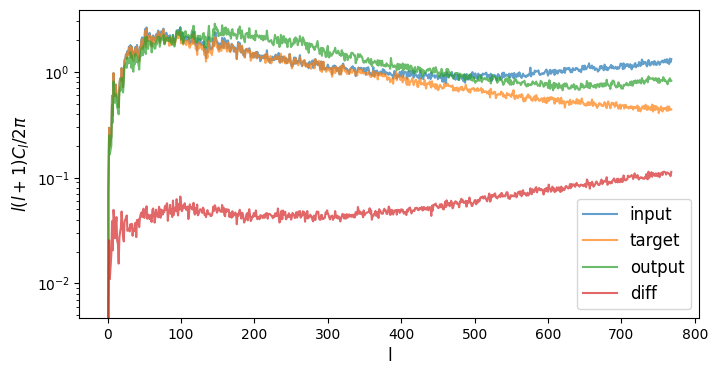

In [169]:
output_cl =hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp)-1), lmax=lmax)
diff_cl = hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp - lr_hp)-1), lmax=lmax)
cls = [input_cl, target_cl, output_cl, diff_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
fig, ax = plot_ps(cls, fig, ax)

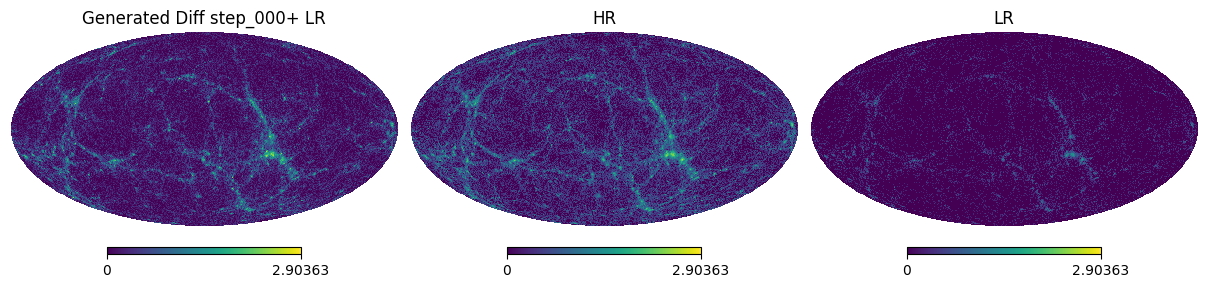

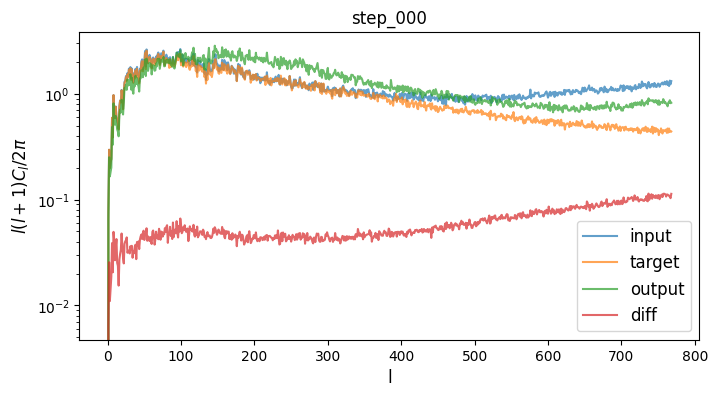

In [170]:
plot_maps_png(99, sr_hp, lr_hp, hr_hp, map_dir + "/png", range_min_hr, range_max_hr, True)
plot_ps_png(99, cls, map_dir + "/ps", 3*nside, True)